In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

# This function reads the gro file, looks for all the strings with that contain the name of the slab residue
# and save the data to the output in the format: ['Atom name and atom number', 'atom number', 'X', 'Y', 'Z']
# Note that gro file should not contain velocities!

def ReadGRO(filename, resname):
    
    lines = []
    slab_gmx = [] 
    file = open(filename)
    
    row_normal_width = 6 # resname atomname atomnumber X Y Z
    row_reduced_width = 5 # resname atomname-atomnumber X Y Z (happens when atomname and atomnumber are too long)
    
    for line in file:
        lines.append(line.split())
    file.close()
    
    # go through the rows in lines list (correspond to rows in the input file)
    # check the number of elements in row
    # save only X Y Z coordinates
    for row in range(len(lines)):
        if resname in lines[row][0]:
            if len(lines[row]) == row_normal_width:
                slab_gmx.append(lines[row][3:6])
            elif len(lines[row]) == row_reduced_width:
                slab_gmx.append(lines[row][2:5])
            else:
                print(lines[row])
                print("Number of row elements error")
    
    # convert all strings to floats
    for atom in slab_gmx:
        for coordinate in range(len(atom)):
            atom[coordinate] = float(atom[coordinate])
           
    return(np.array(slab_gmx))
    

In [2]:
def SlabGeometry(filename, resname):
    
    # Get slab coordinates and convert them into a numpy array
    slab = np.array(ReadGRO(filename, resname))
    
    # Get the extreme slab coordinates and save them to the corresponding X, Y, Z lists:
    
    X = []
    X.append(np.amin(slab.T[0]))
    X.append(np.amax(slab.T[0]))
    
    Y = []
    Y.append(np.amin(slab.T[1]))
    Y.append(np.amax(slab.T[1]))
    
    Z = []
    Z.append(np.amin(slab.T[2]))
    Z.append(np.amax(slab.T[2]))
    
    # Note that the coordinates are in nm
    
    return(X, Y, Z)
    

In [3]:
def GenerateCGbeadCenters(filename, resname, x_points, y_points, z_points):
    
    # Get slab extreme coordinates [[x_min, x_max],[y_min, y_max],[z_min, z_max]]
    slab_geometry = SlabGeometry(filename, resname)
    
    # Calculate x, y and z spacings
    x_spacing = (slab_geometry[0][1] - slab_geometry[0][0]) / x_points
    y_spacing = (slab_geometry[1][1] - slab_geometry[1][0]) / y_points
    z_spacing = (slab_geometry[2][1] - slab_geometry[2][0]) / z_points
    
    spacings = np.array([x_spacing, y_spacing, z_spacing])
    
    # Generate grid points
    grid = []
    for x in range(x_points):
        for y in range(y_points):
            for z in range(z_points):
                grid.append(np.array([float(x),float(y),float(z)]))
    
    # Transform it to a numpy array
    grid_np = np.array(grid)
    
    # Convert the grid to the original coordinate system...
    # ...and move each point by half of spacing
    # We want them to become CG bead centers after all!
    grid_np.T[0] *= x_spacing
    grid_np.T[0] += (slab_geometry[0][0] + x_spacing/2)
    
    grid_np.T[1] *= y_spacing
    grid_np.T[1] += (slab_geometry[1][0] + y_spacing/2)
    
    grid_np.T[2] *= z_spacing
    grid_np.T[2] += (slab_geometry[2][0] + z_spacing/2)
    
    
    return(grid_np, spacings)
    
    

In [4]:
def CGbeadHistogram(AllCGbead_AtomIndexes, Nbins):
    atoms_in_CGbead = []
    for CGbead in AllCGbead_AtomIndexes:
        atoms_in_CGbead.append(len(CGbead))
    atoms_in_CGbead = np.array(atoms_in_CGbead)
    fig = plt.figure(figsize=(12,7))
    plt.ylabel('Count', size=20)
    plt.xlabel('Number of atoms per CG bead', size=20)
    pylab.yticks(fontsize=20)
    pylab.xticks(fontsize=20)
    plt.grid(b=True, which='major' , linestyle='--', color= 'grey', linewidth=1, zorder=1)
    plt.grid(b=True, which='minor', linestyle='--', color= 'grey', linewidth=1, zorder=1)
    plt.hist(atoms_in_CGbead, bins = Nbins)
    plt.show()
    
    return(None)

In [5]:
def outputGRO(filename, resname, atomname, x_points, y_points, z_points):
    atoms = np.array(ReadGRO(filename, resname))
    CGbeads_data = GenerateCGbeadCenters(filename, resname, x_points, y_points, z_points)
    CGbeads = CGbeads_data[0]
    CGbeads = np.around(CGbeads, decimals=3)
    
    with open(filename, 'r') as file:
        lines = file.read().splitlines()
        pbc = lines[-1].split()
    
    
    filename = resname + "_" + str(len(CGbeads)) + "CGbeads.gro"
    file_header = "resname: " + resname + "; " + str(len(CGbeads))+ " " + "CG beads" + "\n" + str(len(CGbeads))
    
    gro_file = open(filename, 'w+')
    gro_file.write(file_header + '\n')
    
    for CGbead_index in range(len(CGbeads)):
        gro_file.write(format(resname).rjust(9))
        gro_file.write(format(atomname + str(CGbead_index+1)).rjust(6))
        gro_file.write(format(str(CGbead_index+1)).rjust(5))
        for axis_index in range(len(CGbeads[CGbead_index])):
            gro_file.write(format(CGbeads[CGbead_index][axis_index], '#.3f').rjust(8))
        gro_file.write("\n")
    
    for axis_index in range(len(pbc)):
        gro_file.write(format(float(pbc[axis_index]), '#.5f').rjust(10))
    gro_file.write("\n")
    gro_file.close()
    print(filename, "saved.")
    return
    

In [6]:
# Find CG beads that belong to the surface and first layers and bulk

def FindSlabLayers(CGbeads, AllCGbead_AtomIndexes):
    
    # Generate an array which contains unique Z-coordinate values
    values_z = np.unique(CGbeads.T[2])

    # Surface CG beads have either minimum or maximum values of Z-coordinate 
    surface_z = [values_z[0], values_z[len(values_z)-1]]
    # First subsurface CG beads have next minimum or next maximum values of Z-coordinate
    first_layer_z = [values_z[1], values_z[len(values_z)-2]]

    # Set coordinate tolerance value for comparing floats
    tol = 1e-5

    # Construct an array of surface CG beads indexes
    CGbeads_surface_indexes = []
    for CGbead_index in range(len(CGbeads)):
        if surface_z[0] - tol <= CGbeads[CGbead_index][2] <= surface_z[0] + tol:
            CGbeads_surface_indexes.append(CGbead_index)
        elif surface_z[1] - tol <= CGbeads[CGbead_index][2] <= surface_z[1] + tol:
            CGbeads_surface_indexes.append(CGbead_index)

    CGbeads_surface_indexes = np.array(CGbeads_surface_indexes)

    # Construct an array of first subsurface CG beads indexes
    CGbeads_first_layer_indexes = []
    for CGbead_index in range(len(CGbeads)):
        if first_layer_z[0] - tol <= CGbeads[CGbead_index][2] <= first_layer_z[0] + tol:
            CGbeads_first_layer_indexes.append(CGbead_index)
        elif first_layer_z[1] - tol <= CGbeads[CGbead_index][2] <= first_layer_z[1] + tol:
            CGbeads_first_layer_indexes.append(CGbead_index)
            
    CGbeads_first_layer_indexes = np.array(CGbeads_first_layer_indexes)
            
    # Construct an array of bulk CG beads (below first subsurface layer)
    CGbeads_bulk_indexes = []
    for CGbead_index in range(len(CGbeads)):
        if not surface_z[0] - tol <= CGbeads[CGbead_index][2] <= surface_z[0] + tol:
            CGbeads_bulk_indexes.append(CGbead_index)
        elif not surface_z[1] - tol <= CGbeads[CGbead_index][2] <= surface_z[1] + tol:
            CGbeads_bulk_indexes.append(CGbead_index)
        elif not first_layer_z[0] - tol <= CGbeads[CGbead_index][2] <= first_layer_z[0] + tol:
            CGbeads_bulk_indexes.append(CGbead_index)
        elif not first_layer_z[1] - tol <= CGbeads[CGbead_index][2] <= first_layer_z[1] + tol:
            CGbeads_bulk_indexes.append(CGbead_index)

    CGbeads_bulk_indexes = np.array(CGbeads_bulk_indexes)
    
    # Construct arrays of surface, first subsurface and bulk CG beads from the main array
    CGbeads_Surface = np.take(AllCGbead_AtomIndexes, CGbeads_surface_indexes)
    CGbeads_FirstLayer = np.take(AllCGbead_AtomIndexes, CGbeads_first_layer_indexes)
    CGbeads_Bulk = np.take(AllCGbead_AtomIndexes, CGbeads_bulk_indexes)
    
    
    return(CGbeads_Surface, CGbeads_FirstLayer, CGbeads_Bulk)

In [7]:
def Initialize(filename, resname, x_points, y_points, z_points, overlap):
    
    # Call ReadGRO function for atomic coordinates
    print("Initializing the input...\n")
    
    atoms = np.array(ReadGRO(filename, resname))
    
    print("Reading", filename, "...")
    print(resname, "residue is selected for the bead mapping...")
    print("Total number of atoms in the slab:", len(atoms), "\n")
    
    # Call GenerateCGbeadCenters for CG bead centers and grid spacings
    CGbeads_data = GenerateCGbeadCenters(filename, resname, x_points, y_points, z_points)
    CGbeads = CGbeads_data[0]
    spacings = CGbeads_data[1]
    
    print("Using", x_points,"x", y_points,"x",z_points, "grid for CG centers...")
    print("Using", np.around(spacings, decimals=4), "as a grid spacing vector...")

    
    print(str(len(CGbeads)), "CG centers will be generated...")
    print("Using additional", overlap, "* spacing for grid cell overlap...\n")
    print("Average number of atoms per CG bead is:", round(float(len(atoms))/float(len(CGbeads)), 4))
    print("")
    
    return(atoms, CGbeads, spacings)

In [8]:
def DistanceCheck(AllCGbead_AtomIndexes, atoms, CGbead_AtomIndexes, 
                  CGbead, spacings, overlap, warning_distance_counter):
    # Check if the distances between CG bead and assigned atoms are within limits
    CGbead_submatrix = np.ones((len(CGbead_AtomIndexes), 3)) * CGbead
    # Subtract 1 from all elements of CGbead_AtomIndexes (indexes) so that 0 is the first element
    distances = np.linalg.norm(CGbead_submatrix - atoms[CGbead_AtomIndexes-1], axis=1)
    if np.any(distances > np.sqrt(3)*np.amax(spacings)*(0.5+overlap)):
        print("Warning!: Distances between the atoms assigned to CG bead number", 
              (len(AllCGbead_AtomIndexes)+1), "are not within acceptable limits.")
        warning_distance_counter += 1
    return(warning_distance_counter)

In [9]:
def MakeFinalChecks(AllCGbead_AtomIndexes, atoms, warning_distance_counter, CGbead_distance_warnings):
    atoms_in_CGbead = np.hstack(AllCGbead_AtomIndexes)
    
    print("Checking the output... \n")
    if len(atoms_in_CGbead) == len(atoms):
        print("All atoms have been assigned to CG beads.")
    elif len(atoms_in_CGbead) < len(atoms):
        print("Warning!: Some atoms were not assigned to CG beads.")
    else:
        print("Warning!: One or more atoms were assigned to multiple CG beads.")
    
    # Check if all indexes are unique
    if len(atoms_in_CGbead) == len(np.unique(atoms_in_CGbead)):
        print("Assigned atoms list do not contain duplicate atom indexes.")
    else:
        print("Warning!: Assigned atoms list contains duplicate atom indexes!")
    
    if warning_distance_counter == 0:
        print("All distances between CG beads and assigned atoms are within acceptable limits.")
    else:
        print(warning_distance_counter, "distance warning(s) occured.")
        print("CG beads:",np.array(CGbead_distance_warnings),
              "have assigned atoms that are too far away from the CG bead...")
    
    return

In [10]:
def GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, overlap):
    
    # I might reduce the amount of comments to make the code a little bit more readible...
    
    # Matrix with the same shape as atomic coordinate matrix. Every vector corresponds to the coordinates of 
    # a certain CG bead
    CGbead_matrix = np.ones((len(atoms), 3)) * CGbead
    
    # Same, but with spacings instead of CG bead coordinates
    spacings_matrix = np.ones((len(atoms), 3)) * spacings
    
    # Computing atomic coordinates relative to the CG bead
    atoms_CGbead_relative = np.absolute((atoms - CGbead_matrix))
    
    # If any atomic coordinate is bigger than the corresponding spacing, True is saved
    # but then it is inverted so that True equals to assigned atom
    # We adding tolerance parameter to 0.5 of spacing, because we want a small overlap to cover everything
    assignement_matrix = np.invert(np.any(atoms_CGbead_relative > spacings_matrix*(0.5+overlap), axis=1))
    
    # Collect indexes where True is
    # Adding unity to every element, because we want indexing to start from 1, not 0
    CGbead_AtomIndexes = np.nonzero(assignement_matrix)[0]+1
   
    # If the final array is not empty
    if len(AllCGbead_AtomIndexes) != 0:
    
        # Create a boolean list where True means that the atom was not assigned yet
        assignement_check = np.isin(CGbead_AtomIndexes, np.hstack(AllCGbead_AtomIndexes), invert=True, 
                                    assume_unique=True)

        # False * any number gives zero, after multiplication we delete zeros - only unassigned atoms are left
        CGbead_AtomIndexes = CGbead_AtomIndexes*assignement_check
        CGbead_AtomIndexes = CGbead_AtomIndexes[CGbead_AtomIndexes != 0]
    
    return(CGbead_AtomIndexes)

In [11]:
# This function takes a CGbead center coordinates, CGbead grid spacings and all atoms coordinates as inputs.
# The function checks if atoms belong to the grid cell of the CG bead and returns the array of these atoms' indexes

def CGBeadMapping(CGbead, spacings, atoms, AllCGbead_AtomIndexes, overlap, atoms_per_CGbead, max_iterations):
    
    flexible_overlap = overlap
    
    # Get CGbead_AtomIndexes
    CGbead_AtomIndexes = GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, overlap)

    if len(CGbead_AtomIndexes) < atoms_per_CGbead:
        for iteration_number in range(max_iterations):
            flexible_overlap += iteration_number*overlap
            CGbead_AtomIndexes = GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, flexible_overlap)
            
    elif len(CGbead_AtomIndexes) > atoms_per_CGbead+1:
        for iteration_number in range(max_iterations):
            flexible_overlap -= iteration_number*overlap
            CGbead_AtomIndexes = GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, flexible_overlap)
    
    '''if len(CGbead_AtomIndexes) < atoms_per_CGbead:
        while len(CGbead_AtomIndexes) < atoms_per_CGbead:
            flexible_overlap += overlap
            CGbead_AtomIndexes = GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, flexible_overlap)
            if flexible_overlap > 100*overlap:
                break
        print("Overlap was increased more than 100 times. Consider increasing overlap parameter.")
        CGbead_AtomIndexes = GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, flexible_overlap)
    
    elif len(CGbead_AtomIndexes) > atoms_per_CGbead+1:
        while len(CGbead_AtomIndexes) > atoms_per_CGbead+1:
            flexible_overlap -= overlap
            CGbead_AtomIndexes = GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, flexible_overlap)
            if flexible_overlap > 100*overlap:
                break
        print("Overlap was decreased more than 100 times. Consider increasing overlap parameter.")
        CGbead_AtomIndexes = GetCGBeadAtomIndexes(CGbead, spacings, atoms, AllCGbead_AtomIndexes, flexible_overlap)'''
    
    
    
    
    
    return(CGbead_AtomIndexes)

In [12]:
def CGBeadMappingMain(filename, resname, x_points, y_points, z_points, overlap, max_iterations):
    
    # The counter accumulates warnings about distances which are not within acceptable limits
    warning_distance_counter = 0
    CGbead_distance_warnings = []
    
    atoms_and_CGbeads_data = Initialize(filename, resname, x_points, y_points, z_points, overlap)
    atoms = atoms_and_CGbeads_data[0]
    CGbeads = atoms_and_CGbeads_data[1]
    spacings = atoms_and_CGbeads_data[2]
    
    # Get the floor of N_atoms/N_CGbeads division
    atoms_per_CGbead = len(atoms)//len(CGbeads)
    
    # Create list containing indexes of atoms belonging to one CG bead
    AllCGbead_AtomIndexes = []
    
    # Go through every CG bead
    for CGbead_index in range(len(CGbeads)):
        
        # Call CGBeadMap function
        CGbead_AtomIndexes = CGBeadMapping(CGbeads[CGbead_index], spacings, atoms, AllCGbead_AtomIndexes,
                                           overlap, atoms_per_CGbead, max_iterations)
        
        # Call DistanceCheck function
        #distance_check_output = DistanceCheck(AllCGbead_AtomIndexes, atoms, CGbead_AtomIndexes, CGbeads[CGbead_index], 
        #                                      spacings, overlap, warning_distance_counter)
        
        # If the warning_distance_counter became larger - save the index of the problematic CG bead
        #if distance_check_output > warning_distance_counter:
        #    CGbead_distance_warnings.append(CGbead_index)
        ## Append results to the final array
        #else:
        #    AllCGbead_AtomIndexes.append(CGbead_AtomIndexes)
        
        AllCGbead_AtomIndexes.append(CGbead_AtomIndexes)
        
    # Make some final checks
    MakeFinalChecks(AllCGbead_AtomIndexes, atoms, warning_distance_counter, CGbead_distance_warnings)
    
    # Find surface, subsurface and bulk CG beads
    AllCGbead_AtomIndexes_Diff = FindSlabLayers(CGbeads, np.array(AllCGbead_AtomIndexes))
    
    # The final result is a tuple where the first element contains surface beads, 
    # second - subsurface and the last - bulk CG beads
        
    return(AllCGbead_AtomIndexes_Diff)   

In [17]:
%%time
test1 = CGBeadMappingMain('anatase-101-POPE.gro', '1H151', 16, 16, 9, 0.01, 1)

Initializing the input...

Reading anatase-101-POPE.gro ...
1H151 residue is selected for the bead mapping...
Total number of atoms in the slab: 13910 

Using 16 x 16 x 9 grid for CG centers...
Using [0.4408 0.4337 0.3884] as a grid spacing vector...
2304 CG centers will be generated...
Using additional 0.01 * spacing for grid cell overlap...

Average number of atoms per CG bead is: 6.0373

Checking the output... 

All atoms have been assigned to CG beads.
Assigned atoms list do not contain duplicate atom indexes.
All distances between CG beads and assigned atoms are within acceptable limits.
CPU times: user 4.85 s, sys: 11.9 ms, total: 4.86 s
Wall time: 4.86 s


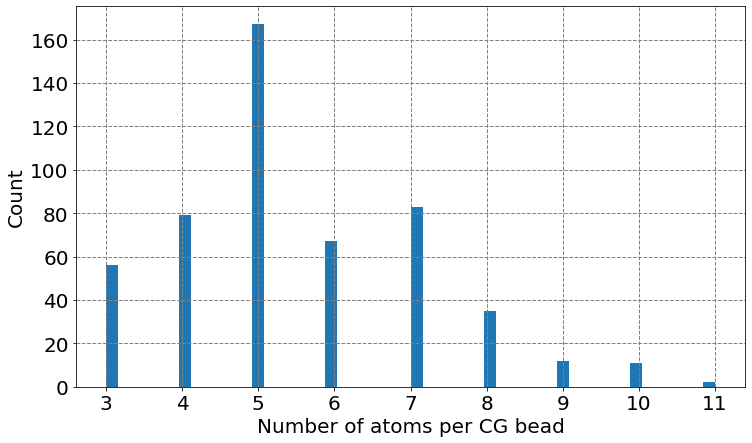

In [19]:
CGbeadHistogram(test1[0], 50)

In [28]:
outputGRO('anatase-101-POPE.gro', '1H151', 'C', 12, 12, 6)

1H151_864CGbeads.gro saved.
